In [1]:
import numpy as np
from numpy.random import seed
seed(440232650)
from tensorflow import set_random_seed
set_random_seed(440232650)
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import tensorflow
warnings.filterwarnings('ignore') 
import os, random, cv2, h5py
from glob import glob
from sklearn.preprocessing import OneHotEncoder
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, jaccard_score

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from keras.layers import Input, Dropout, Flatten, Dense, AveragePooling2D, Conv2D, GlobalAveragePooling2D
from keras.optimizers import Adam
import np_utils
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger

/home/s188/sarah_environments/sarah_thesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/s188/sarah_environments/sarah_thesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/s188/sarah_environments/sarah_thesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/s188/sarah_envir

In [2]:
import segmentation_models as sm
from segmentation_models import Unet
#from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss

#from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [3]:
weights = [0.4, 0.6, 0.5, 1]

In [4]:
import os

In [5]:
IOU = sm.metrics.IOUScore() #iou is also known as the jaccard score
Fscore = sm.metrics.FScore() #also known as dice coeff

loss = sm.losses.DiceLoss(class_weights=weights)
#loss = sm.losses.DiceLoss()

learning_rate=0.001
lr='1e-3'
#loss = sm.losses.CategoricalCELoss(class_weights = weights)
loss_name = 'DiceLoss'

metrics = [IOU, Fscore]

In [6]:
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [8]:
class_dict = {0:'BG', 1:'H',2:'L',3:'C'}

In [9]:
ytrain_dir = 'Masks_cat_4/Train'
xtrain_dir = 'Images/Segmenting/Train'

ytest_dir = 'Masks_cat_4/Test'
xtest_dir = 'Images/Segmenting/Test'

yval_dir = 'Masks_cat_4/Val'
xval_dir = 'Images/Segmenting/Val'

In [10]:
image_size = 256
batch_size = 8
epochs = 100
backbone = 'vgg16'

In [11]:
#save_path = f'Unet_b{batch_size}_e{epochs}_{backbone}_{lr}_fromscratch_weights_uncropped'

In [28]:
save_path = 'Unet_b8_e200_vgg16_1e-4_aug_fromscratch_noweights_uncropped'

In [13]:
#train_img = cv2.imread(os.path.join(img_folder,n[2]))/255.

In [14]:
#centre_img = train_img - cv2.meanStdDev(train_img)[0][0][0]

In [15]:
#std_img = centre_img/cv2.meanStdDev(train_img)[1][0][0]

In [16]:
#centre_img.max()

In [17]:
# own datagenerator

def data_gen(img_folder, mask_folder, batch_size=8, image_size=256, classes=4):
    c=0
    n=os.listdir(img_folder)
    random.shuffle(n)
    
    while (True):
        img = np.zeros((batch_size, image_size, image_size, 1)).astype('float')
        mask = np.zeros((batch_size, image_size, image_size, classes)).astype('float')
        
        for i in range(c, c+batch_size):
            
            train_img = cv2.imread(os.path.join(img_folder,n[i]), cv2.IMREAD_GRAYSCALE)/255.
            train_img = cv2.resize(train_img, (image_size, image_size))
            train_img = train_img.reshape([image_size, image_size,1])
            
            img[i-c] = train_img #add to array img[0] img [1] etc
            
            train_mask = cv2.imread(os.path.join(mask_folder,n[i]), cv2.IMREAD_GRAYSCALE)
            train_mask = cv2.resize(train_mask, (image_size, image_size))
            train_mask = train_mask.ravel()
            train_mask = to_categorical(train_mask, num_classes=classes)
            train_mask = train_mask.reshape([image_size, image_size, classes])
            
            mask[i-c] = train_mask
            
        c+=batch_size
        if (c+batch_size>=len(os.listdir(img_folder))):
            c=0
            random.shuffle(n)
        
        yield img, mask

In [18]:
def test_gen(img_folder, mask_folder, batch_size=51, image_size=256, classes=4):
    c=0
    n=os.listdir(img_folder)
    n.sort() #always evaluate in the same order 
    #remove shuffling
    while (True):
        img = np.zeros((batch_size, image_size, image_size, 1)).astype('float')
        mask = np.zeros((batch_size, image_size, image_size, classes)).astype('float')
        
        for i in range(c, c+batch_size):
            
            train_img = cv2.imread(os.path.join(img_folder,n[i]), cv2.IMREAD_GRAYSCALE)/255.
            train_img = cv2.resize(train_img, (image_size, image_size))
            train_img = train_img.reshape([image_size, image_size,1])
            
            img[i-c] = train_img #add to array img[0] img [1] etc
            
            train_mask = cv2.imread(os.path.join(mask_folder,n[i]), cv2.IMREAD_GRAYSCALE)
            train_mask = cv2.resize(train_mask, (image_size, image_size))
            train_mask = train_mask.ravel()
            train_mask = to_categorical(train_mask, num_classes=classes)
            train_mask = train_mask.reshape([image_size, image_size, classes])
            
            mask[i-c] = train_mask
            
        c+=batch_size
        if (c+batch_size>=len(os.listdir(img_folder))):
            c=0
        
        yield img, mask

In [29]:
train_gen = data_gen(xtrain_dir, ytrain_dir,image_size=image_size, batch_size=batch_size)
val_gen = data_gen(xval_dir, yval_dir, image_size=image_size,batch_size=batch_size)
val_pred_generator =  test_gen(xval_dir, yval_dir, image_size=image_size, batch_size=51)
test_generator = test_gen(xtest_dir, ytest_dir, image_size=image_size, batch_size=51)

In [20]:
no_training_images = len(os.listdir(xtrain_dir))
no_val_images = len(os.listdir(xval_dir))


weights_path = filepath=(f'Weights/{save_path}.h5')

checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
csv_logger = CSVLogger(f'TrainingLog/{save_path}.out', append=True, separator=';')

earlystopping = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

callbacks_list = [checkpoint, csv_logger, earlystopping]


In [21]:
model = Unet(backbone_name='vgg16', encoder_weights=None, classes=4, activation = 'softmax', encoder_freeze = False, input_shape=(image_size, image_size, 1))


In [30]:
model.load_weights('Weights/Unet_b8_e200_vgg16_1e-4_aug_fromscratch_noweights_uncropped.h5')

In [31]:
model.compile(opt, loss=loss, metrics=metrics)

In [23]:
#model.load_weights(f'Weights/Unet_s{image_size}_b{batch_size}_e{epochs}_{backbone}_{loss_name}.best.hdf5')

In [24]:
results = model.fit_generator(train_gen, epochs=epochs, 
                          steps_per_epoch = (no_training_images//batch_size),
                          validation_data=val_gen,
                          validation_steps=(no_val_images//batch_size), 
                             verbose=1, 
                             callbacks = callbacks_list)


Epoch 1/100
29/29 [==============================] - 9s 309ms/step - loss: 0.7657 - iou_score: 0.3294 - f1-score: 0.4500 - val_loss: 0.9382 - val_iou_score: 0.0713 - val_f1-score: 0.1250

Epoch 00001: val_loss improved from inf to 0.93818, saving model to Weights/Unet_b8_e100_vgg16_1e-3_fromscratch_weights_uncropped.h5
Epoch 2/100
29/29 [==============================] - 4s 129ms/step - loss: 0.6529 - iou_score: 0.5082 - f1-score: 0.6369 - val_loss: 0.8185 - val_iou_score: 0.3072 - val_f1-score: 0.3919

Epoch 00002: val_loss improved from 0.93818 to 0.81848, saving model to Weights/Unet_b8_e100_vgg16_1e-3_fromscratch_weights_uncropped.h5
Epoch 3/100
29/29 [==============================] - 4s 127ms/step - loss: 0.6103 - iou_score: 0.5708 - f1-score: 0.6961 - val_loss: 0.8992 - val_iou_score: 0.1422 - val_f1-score: 0.2203

Epoch 00003: val_loss did not improve from 0.81848
Epoch 4/100
29/29 [==============================] - 4s 127ms/step - loss: 0.5937 - iou_score: 0.5988 - f1-score: 

29/29 [==============================] - 4s 127ms/step - loss: 0.4275 - iou_score: 0.8685 - f1-score: 0.9283 - val_loss: 0.4664 - val_iou_score: 0.7963 - val_f1-score: 0.8824

Epoch 00029: val_loss did not improve from 0.44494
Epoch 30/100
29/29 [==============================] - 4s 128ms/step - loss: 0.4246 - iou_score: 0.8743 - f1-score: 0.9318 - val_loss: 0.4492 - val_iou_score: 0.7949 - val_f1-score: 0.8812

Epoch 00030: val_loss did not improve from 0.44494
Epoch 31/100
29/29 [==============================] - 4s 128ms/step - loss: 0.4211 - iou_score: 0.8821 - f1-score: 0.9363 - val_loss: 0.4448 - val_iou_score: 0.8195 - val_f1-score: 0.8971

Epoch 00031: val_loss improved from 0.44494 to 0.44478, saving model to Weights/Unet_b8_e100_vgg16_1e-3_fromscratch_weights_uncropped.h5
Epoch 32/100
29/29 [==============================] - 4s 128ms/step - loss: 0.4208 - iou_score: 0.8822 - f1-score: 0.9364 - val_loss: 0.4493 - val_iou_score: 0.8152 - val_f1-score: 0.8941

Epoch 00032: val_l

In [25]:
#from keras.models import load_model

In [26]:
#model = load_model(f'Models/{save_path}.hdf5')

In [27]:
#model.save_weights(f'Weights/{save_path}_lr00001.h5')

In [28]:
path = f'TrainingLog/{save_path}.out'
history = pd.read_csv(path, sep=';')

In [29]:
def plot_history(history, save=False, name=None):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.plot(history['iou_score'])
    ax1.plot(history['val_iou_score'])
    ax1.title.set_text('Model Accuracy')
    ax1.set_ylabel('Jaccard Score')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    
    # Plot training & validation loss values
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.title.set_text('Model loss')
    ax2.set_ylabel('Jaccard Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    fig.tight_layout()
    fig.show()
    if save==False:
        return
    else:
        fig.savefig(f'Figures/{name}.png')
        
    return

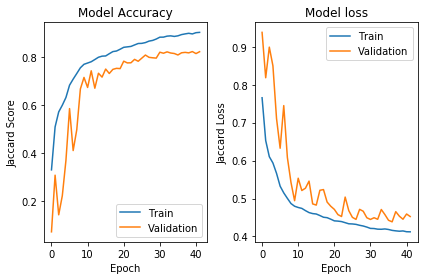

In [30]:
plot_history(history, save = True, name = save_path)

In [31]:
def get_class_jaccard(image_folder, mask_folder, generator):
    image_names = os.listdir(image_folder)
    image_names.sort()
    
    predictions = model.predict_generator(generator, steps=1)
    
    ytrue = np.zeros((51, image_size, image_size, 4)).astype('float')

    for i in range(51):
        target = cv2.imread(os.path.join(mask_folder, image_names[i]), cv2.IMREAD_GRAYSCALE)
        target = cv2.resize(target, (image_size, image_size))
        target = target.ravel()
        target = to_categorical(target, num_classes=4)
        target = target.reshape([image_size, image_size, 4])
        
        ytrue[i] = target
    
    ypred = np.argmax(predictions, axis=-1)
    ytrue = np.argmax(ytrue, axis=-1)
    
    scores = jaccard_score(ytrue.ravel(), ypred.ravel(), average=None)
    
    return print(f'BG: {scores[0]}, Heart: {scores[1]}, Lungs: {scores[2]}, Clavicles: {scores[3]}')

In [32]:
get_class_jaccard(xtest_dir, ytest_dir, test_generator)

BG: 0.9514873454816162, Heart: 0.7197902302751441, Lungs: 0.8790576746687999, Clavicles: 0.6977175236985649


In [33]:
get_class_jaccard(xval_dir, yval_dir, val_pred_generator)

BG: 0.9481907240931536, Heart: 0.7339389539860705, Lungs: 0.8885689225383687, Clavicles: 0.705306749490699


In [42]:
#image_names = os.listdir(xval_dir)
#image_names.sort()
#predictions = model.predict_generator(val_pred_generator, steps=1)
#ypred = np.argmax(predictions, axis=-1)

In [32]:
image_names = os.listdir(xtest_dir)
image_names.sort()
predictions = model.predict_generator(test_generator, steps=1)
ypred = np.argmax(predictions, axis=-1)

In [31]:
def plot_pred(index, predictions = ypred, save=False):
    img = cv2.imread(os.path.join('Images/Segmenting/Val/',image_names[index]), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_size, image_size))   
    
    target = cv2.imread(os.path.join(yval_dir, image_names[index]), cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, (image_size, image_size))
    
    scores = jaccard_score(target.ravel(), ypred[index].ravel(), average=None)
    
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(img, cmap='gray')
    im2 = plt.imshow(ypred[index], cmap = 'plasma', alpha=0.4)
    plt.axis('off')
    plt.annotate(f'IoU Heart: {round(scores[1]*100,2)}, Lungs: {round(scores[2]*100,2)},\n Clavicles: {round(scores[3]*100,2)}',(image_size*0.1, image_size*0.95), color='white')
    
    if save == True:
        plt.savefig(f'Figures/{save_path}_{image_names[index]}.png')
    
    plt.show()
    

In [33]:
def plot_testpred(index, predictions = ypred, save=False):
    img = cv2.imread(os.path.join('Images/Segmenting/Test/',image_names[index]), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_size, image_size))   
    
    target = cv2.imread(os.path.join(ytest_dir, image_names[index]), cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, (image_size, image_size))
    
    scores = jaccard_score(target.ravel(), ypred[index].ravel(), average=None)
    
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(img, cmap='gray')
    im2 = plt.imshow(ypred[index], cmap = 'plasma', alpha=0.4)
    plt.axis('off')
    plt.annotate(f'IoU Heart: {round(scores[1]*100,2)}, Lungs: {round(scores[2]*100,2)},\n Clavicles: {round(scores[3]*100,2)}',(image_size*0.1, image_size*0.95), color='white')
    
    if save == True:
        plt.savefig(f'Figures/TestUCFigsUW/{save_path}_{image_names[index]}.png')
    
    plt.show()

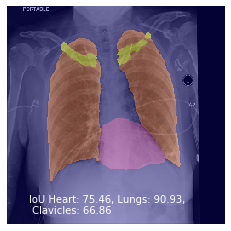

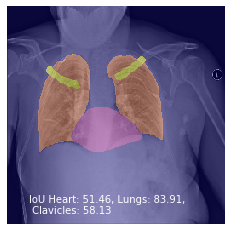

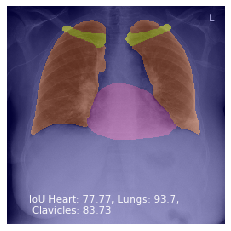

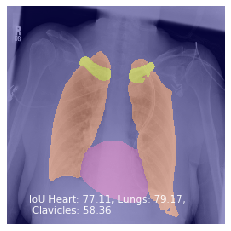

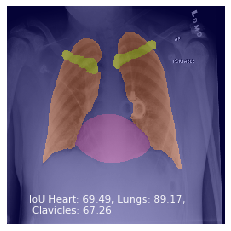

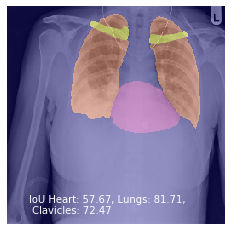

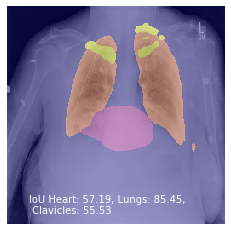

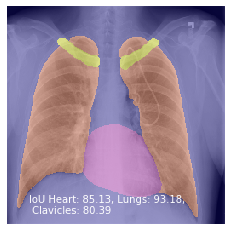

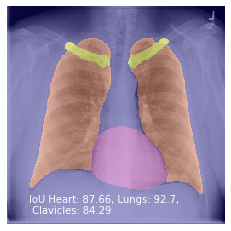

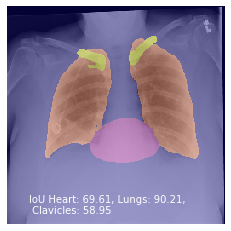

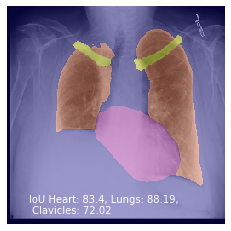

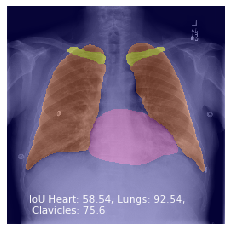

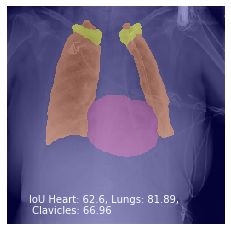

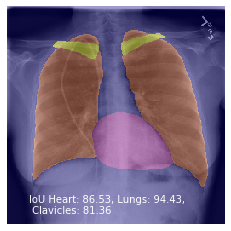

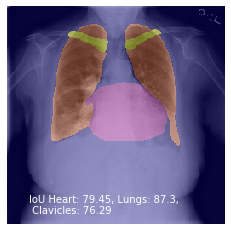

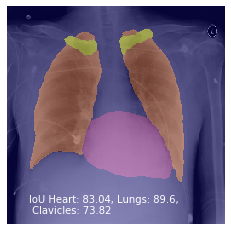

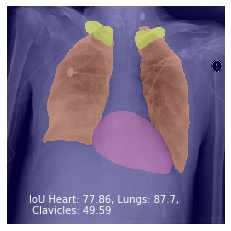

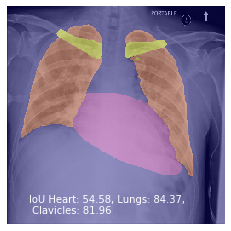

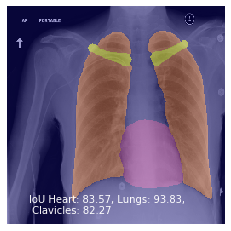

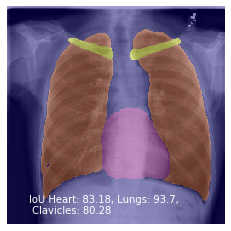

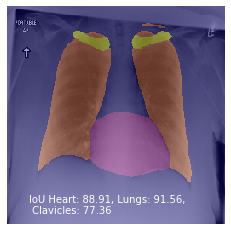

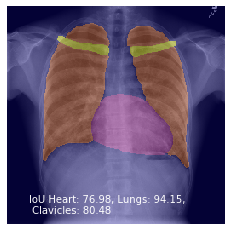

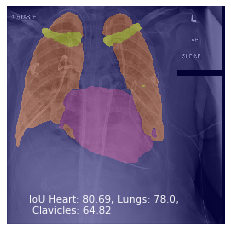

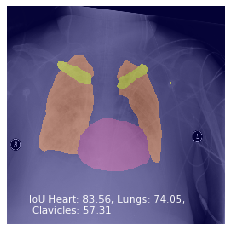

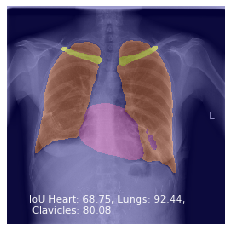

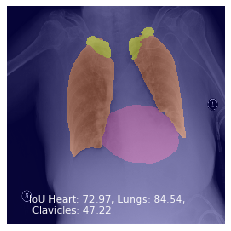

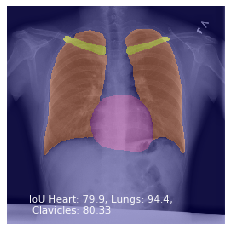

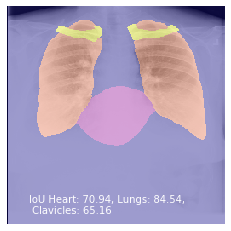

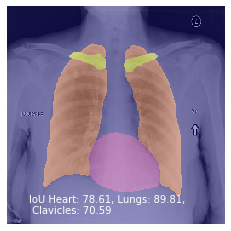

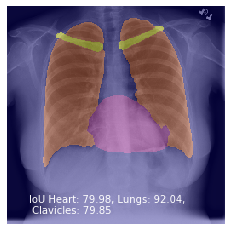

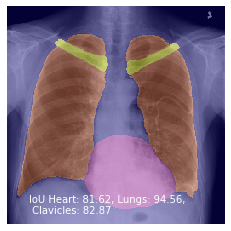

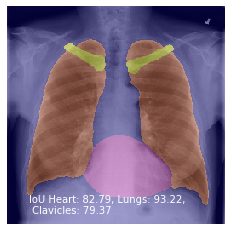

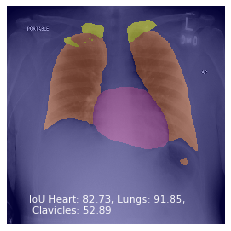

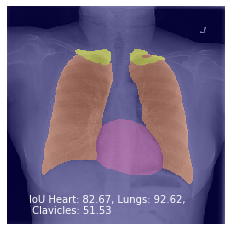

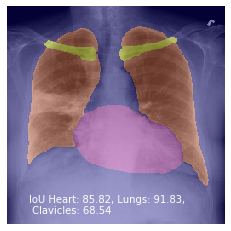

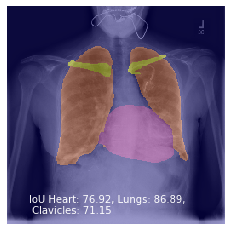

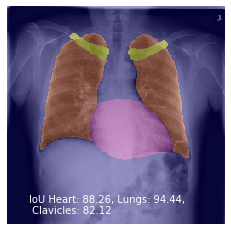

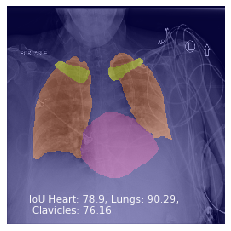

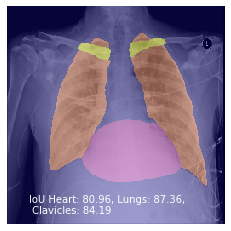

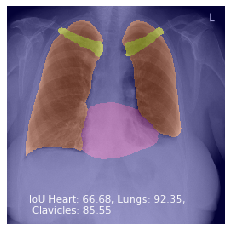

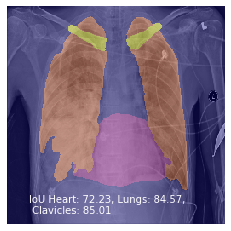

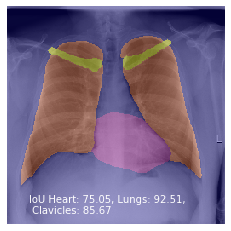

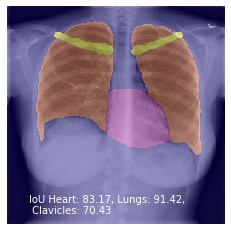

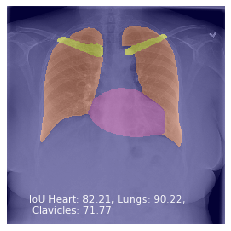

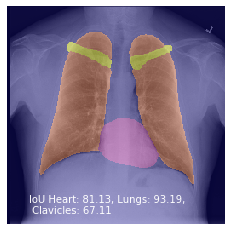

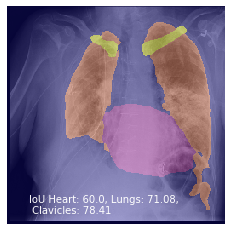

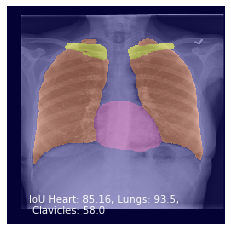

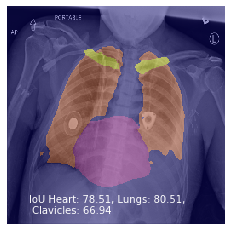

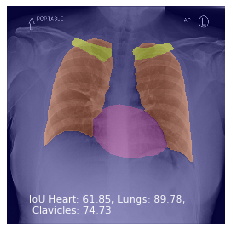

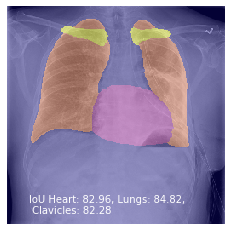

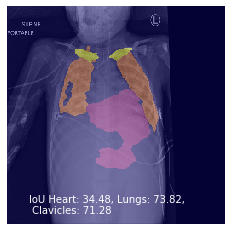

In [34]:
for i in range(len(image_names)):
    plot_testpred(i, predictions = ypred, save=True)

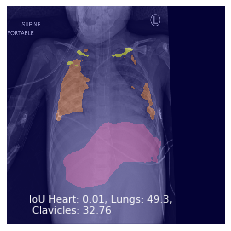

In [34]:
plot_testpred(50, ypred, save=True)

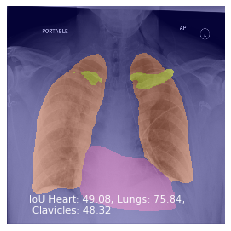

In [47]:
plot_testpred(26, ypred, save=True)

In [34]:
#img = cv2.imread(os.path.join('Images/Segmenting/Val/',image_names[2]), cv2.IMREAD_GRAYSCALE)
#img = cv2.resize(img, (image_size, image_size))
#
#fig = plt.figure(frameon=False)
#im1 = plt.imshow(img, cmap='gray')
#im2 = plt.imshow(predictions[2,:,:,3], cmap = 'plasma', alpha=0.4)
#plt.axis('off')
##plt.annotate(f'IoU Heart: {round(scores[1]*100,2)}, Lungs: {round(scores[2]*100,2)},\n Clavicles: {round(scores[3]*100,2)}',(image_size*0.1, image_size*0.95), color='white')
#plt.savefig(f'Figures/Test/epoch14clavicles.png')
#plt.show()

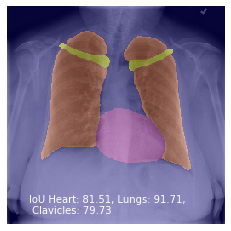

In [35]:
plot_pred(1, ypred, save=True)

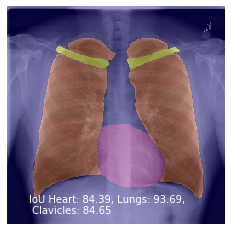

In [36]:
plot_pred(18, ypred, save=True)

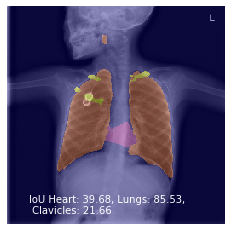

In [37]:
plot_pred(23, ypred, save=True)

In [20]:
folders = ['No Finding', 'Other', 'Pneumonia']
path = 'Images/Test'

In [21]:
def get_class_jaccard_disease(image_folder, mask_folder):
    image_names = os.listdir(image_folder)
    image_names.sort()
    
    gen = test_gen(image_folder, ytest_dir, image_size=image_size, batch_size=len(image_names))
    
    predictions = model.predict_generator(gen, steps=1)
    
    ytrue = np.zeros((len(image_names), image_size, image_size, 4)).astype('float')

    for i in range(len(image_names)):
        target = cv2.imread(os.path.join(mask_folder, image_names[i]), cv2.IMREAD_GRAYSCALE)
        target = cv2.resize(target, (image_size, image_size))
        target = target.ravel()
        target = to_categorical(target, num_classes=4)
        target = target.reshape([image_size, image_size, 4])
        
        ytrue[i] = target
    
    ypred = np.argmax(predictions, axis=-1)
    ytrue = np.argmax(ytrue, axis=-1)
    
    scores = jaccard_score(ytrue.ravel(), ypred.ravel(), average=None)
    
    return print(f'{os.path.basename(image_folder)}BG: {scores[0]}, Heart: {scores[1]}, Lungs: {scores[2]}, Clavicles: {scores[3]}')

In [22]:
for i in range(3):
    target_folder = os.path.join(path, folders[i])
    get_class_jaccard_disease(target_folder, ytest_dir)


No FindingBG: 0.963115597066892, Heart: 0.773143497862599, Lungs: 0.9153309581223039, Clavicles: 0.7185022945348352
OtherBG: 0.9522217141593765, Heart: 0.7709469842489435, Lungs: 0.8868688046161725, Clavicles: 0.7230500801659907
PneumoniaBG: 0.945482905998566, Heart: 0.7166454891994918, Lungs: 0.8709877748008303, Clavicles: 0.720794983311419
